# Artificial Neural Networks and Deep Learning---## Homework 1: Minimal Working ExampleTo make your first submission, follow these steps:1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.2. Upload the `training_set.npz` file to this folder.3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.4. Load and process the data.5. Implement and train your model.6. Submit the generated `.zip` file to Codabench.

## 🌐 Connect Colab to Google Drive

In [1]:
!pip install tensorflow==2.17.0 keras==3.4.1 tensorflow-decision-forests==1.10.0 tensorflow-text==2.17.0 tf-keras==2.17.0 keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 83.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 100.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.3 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
  Att

## ⚙️ Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras_cv

np.random.seed(42)
tf.random.set_seed(42);


2024-11-19 15:23:28.314850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 15:23:28.336521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 15:23:28.343235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ⏳ Load the Data

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Carica il dataset
data = np.load('/kaggle/input/blood-cells/training_set.npz')
X_train = data['images']
y_train = data['labels']


# Carica il dataset
data2 = np.load('/kaggle/input/blood-cells/test_set.npz')
X_test2 = data['images']
y_test2 = data['labels']



In [5]:
import hashlib

def image_hash(image):
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

unique_images = []
unique_labels = []
duplicate_positions = set()

seen_hashes = {}

for i in range(len(X_train)):
    img_hash = image_hash(X_train[i])
    if img_hash not in seen_hashes:
        if i not in duplicate_positions:
            unique_images.append(X_train[i])
            unique_labels.append(y_train[i])
        seen_hashes[img_hash] = i
    else:
        duplicate_positions.add(seen_hashes[img_hash])
        duplicate_positions.add(i)

X_train = [X_train[i] for i in range(len(X_train)) if i not in duplicate_positions]
y_train = [y_train[i] for i in range(len(y_train)) if i not in duplicate_positions]

X_train = np.array(X_train)
y_train = np.array(y_train)


In [6]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# Extract unique classes and their counts
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Original distribution:", class_counts)

# Maximum number of samples for a class
max_samples = max(class_counts.values())

# New balanced dataset
X_balanced = []
y_balanced = []

# Oversampling for each class
for cls in class_counts:
    # Filter samples for the current class
    X_class = X_train[np.where(y_train == cls)[0]]
    y_class = y_train[y_train == cls]
    
    # Calculate the number of samples to add
    samples_to_add = max_samples - len(X_class)
    
    if samples_to_add > 0:
        # Augment the samples to add
        augmented_images = []
        for _ in range(samples_to_add):
            augmented_image = data_augmentation(X_class[np.random.randint(len(X_class))][np.newaxis, ...])
            augmented_images.append(augmented_image.numpy()[0])
        
        # Add the original and augmented samples to the balanced dataset
        X_balanced.append(np.concatenate([X_class, np.array(augmented_images)]))
        y_balanced.append(np.concatenate([y_class, np.full(samples_to_add, cls)]))
    else:
        # Add the original samples to the balanced dataset (if no oversampling is needed)
        X_balanced.append(X_class)
        y_balanced.append(y_class)

# Concatenate the balanced dataset
X_train = np.concatenate(X_balanced)
y_train = np.concatenate(y_balanced)

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))
print("Balanced distribution of classes:", class_counts_balanced)


I0000 00:00:1732029970.761334      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732029970.761675      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732029970.771805      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732029970.772090      30 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Original distribution: {0: 848, 1: 2177, 2: 1085, 3: 2020, 4: 849, 5: 991, 6: 2330, 7: 1643}
Balanced distribution of classes: {0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}


In [6]:

# Converti y in one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test2 = tf.keras.utils.to_categorical(y_test2, num_classes=8)


In [7]:
# split train in training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Preprocessing

In [8]:
def augment(images, labels):
    
    augmenter = keras_cv.layers.Augmenter(
    layers = [
            keras_cv.layers.RandomFlip(
                mode="horizontal_and_vertical"
            ),
            keras_cv.layers.RandomRotation(
                factor=0.2,
                fill_mode='nearest'
            ),
            keras_cv.layers.MixUp(
                alpha=0.5,
            ),
            keras_cv.layers.CutMix(
                alpha=0.5
            ),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),

        ]
    )
        
    inputs = {"images": images, "labels": labels}
    output = augmenter(inputs)
    return output["images"], output["labels"]

In [9]:
# Funzione per prendere immagini ed etichette casuali
def sample_random_images(dataset, sample_size=5):
    random_samples = dataset.shuffle(buffer_size=1000).take(sample_size)
    images = []
    labels = []
    for image, label in random_samples:
        images.append(image.numpy())
        labels.append(label.numpy())
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

# Converte i dati di addestramento in tf.data.Dataset
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))


In [10]:
sample_size = 4000
random_X, random_y = sample_random_images(X_train_dataset, sample_size)
aug_images, aug_labels = augment(random_X, random_y)

In [11]:
X_train = tf.concat([X_train, aug_images], axis=0)
y_train = tf.concat([y_train, aug_labels], axis=0)

In [70]:
print(X_train.shape)
print(y_train.shape)

(20776, 96, 96, 3)
(20776, 8)


In [13]:
sample_size = 7000

augmenter = tf.keras.Sequential([
            keras_cv.layers.RandAugment([0,255],3,0.5)
            keras_cv.layers.AugMix([0,255],0.4),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
    ]
)
    
random_X, random_y = sample_random_images(X_train_dataset, sample_size)
random_y = tf.cast(random_y, dtype=tf.float32)

aug_images = augmenter(random_X)

In [14]:
X_train = tf.concat([X_train, aug_images], axis=0)
y_train = tf.concat([y_train, random_y], axis=0)

In [15]:
X_train = X_train.numpy()
y_train = y_train.numpy()

In [51]:
print(train_dataset.shape)

AttributeError: '_MapDataset' object has no attribute 'shape'

In [128]:
print(aug_images.shape)
print(aug_labels.shape)

(1000, 96, 96, 3)
(1000, 8)


In [19]:
X_train = X_train.numpy()
y_train = y_train.numpy()

In [136]:
print(X_train.shape)
print(y_train.shape)

(12748, 96, 96, 3)
(12748, 8)


In [ ]:
X_train=tf.cast(X_train, dtype=tf.float32)


Class tf.Tensor([0.     0.135  0.     0.     0.5503 0.315  0.     0.    ], shape=(8,), dtype=float16)


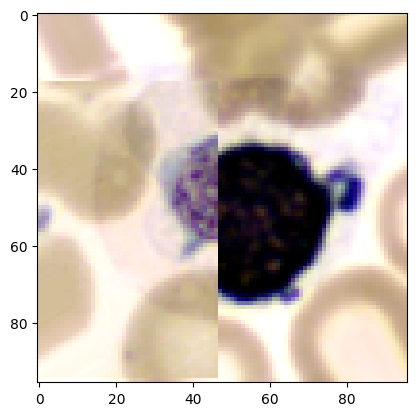

In [75]:
import matplotlib.pyplot as plt

plt.imshow(X_train[-4] / 255.0)
print('Class', aug_labels[1])

## 🛠️ Train and Save the Model

tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0.], shape=(8,), dtype=float16)


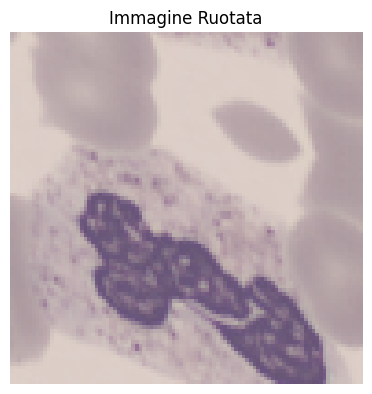

In [82]:
import matplotlib.pyplot as plt
import keras_cv

data_augmentation = model.get_augmentation_layer()

# Applica la rotazione casuale
rotated_image = data_augmentation(X_train[0])
print(y_train[6001])

# Visualizza l'immagine originale e quella ruotata
plt.figure(figsize=(10, 5))

# Mostra l'immagine ruotata
plt.subplot(1, 2, 1)
plt.imshow(X_train[0] / 255.0)
plt.title("Immagine Ruotata")
plt.axis('off')

'''
# Mostra l'immagine ruotata
plt.subplot(1, 2, 2)
plt.imshow(rotated_image / 255.0)
plt.title("Immagine Ruotata")
plt.axis('off')'''

plt.show()

In [16]:
import numpy as np
import tensorflow as tf
import keras_cv
from tensorflow import keras as tfk
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import LambdaCallback
import random
import keras
from keras.saving import register_keras_serializable
from sklearn.utils.class_weight import compute_class_weight

def spatial_attention(input_tensor):
    """
    Spatial Attention Block.
    
    Args:
        input_tensor (tf.Tensor): Input feature map, shape (batch, height, width, channels).

    Returns:
        tf.Tensor: Output tensor after applying spatial attention.
    """
    # Media e massimo pooling lungo l'asse dei canali come livelli Keras
    avg_pool = tfk.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = tfk.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)

    # Concatenazione delle due mappe di attenzione
    concat = tfk.layers.Concatenate(axis=-1)([avg_pool, max_pool])  # Shape: (batch, height, width, 2)

    # Convoluzione per generare la mappa di attenzione spaziale
    attention = tfk.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)  # Shape: (batch, height, width, 1)

    # Scala l'input con la mappa di attenzione
    output = tfk.layers.Multiply()([input_tensor, attention])  # Shape: (batch, height, width, channels)

    return output

class MyModel:
    def __init__(self):
        """
        Inizializza lo stato interno del modello MobileNetV3Small pre-addestrato.
        """
        self.strategy = tf.distribute.MirroredStrategy()
        self.neural_network = self.create_model()
        
    def get_augmentation_layer(self):
        return tf.keras.Sequential([
            # Rotazione casuale
            keras.layers.RandomRotation(0.5, fill_mode='reflect'),

            # Zoom casuale in altezza
            keras.layers.RandomZoom(height_factor=(-0.2, 0.7), fill_mode='nearest'),

            # Altri tipi di augmentazioni
            keras.layers.RandomZoom(height_factor=(0.0, 0.0), width_factor=(-0.2, 0.2), fill_mode='nearest'),
            keras.layers.RandomFlip(mode="horizontal"),
            keras.layers.RandomFlip(mode="vertical"),
            keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
            
            keras.layers.RandomBrightness(0.3),
            #keras_cv.layers.RandomHue(0.3, [0,255]),
            keras_cv.layers.RandomContrast([0, 255], 0.3),
            keras_cv.layers.RandomGaussianBlur(2, 2),
            #keras_cv.layers.RandomCutout(0.3, 0.3,"gaussian_noise"),

            # Aggiunta di rumore gaussiano
            keras.layers.GaussianNoise(0.05)
        ])


    def create_model(self):
        """
        Crea e restituisce un modello
        """
        # Definisci i layer di data augmentation
        data_augmentation = self.get_augmentation_layer()
        
        with self.strategy.scope():

            # Utilizza una rete pre-addestrata
            model_pretrained = tfk.applications.ConvNeXtBase(
                input_shape=(96, 96, 3),
                include_top=False,
                weights='imagenet',
                pooling=None
            )
            self.model_name_pretrained = 'convnext_base'

            print("number of layers:")
            print(len(model_pretrained.layers))

            # Costruisci il modello
            inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')    
            x = data_augmentation(inputs)
            x = model_pretrained(x) 
            
            # Batch Normalization dopo il modello pre-addestrato
            x = tfk.layers.BatchNormalization()(x)

            # Squeeze-and-Excitation (SE Block)
            se = tfk.layers.GlobalAveragePooling2D()(x)  # Riduce a (batch_size, channels)
            se = tfk.layers.Dense(se.shape[-1] // 16, activation='relu')(se)  # Compress
            se = tfk.layers.Dense(se.shape[-1] * 16, activation='sigmoid')(se)  # Expand
            x = tfk.layers.Multiply()([x, tfk.layers.Reshape((1, 1, -1))(se)])  # Scala i canali

        
            # Global Pooling (per ridurre la dimensionalità)
            x = tfk.layers.GlobalAveragePooling2D()(x)

            # Livelli Fully Connected con Batch Normalization e Leaky ReLU
            x = tfk.layers.Dense(512)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)

            x = tfk.layers.Dense(256)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)
            
            outputs = tfk.layers.Dense(8, activation='softmax', name='output_layer')(x)

            model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

            return model

    def train_transfer_learning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        """
        Pre-addestra il modello con i layer congelati.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = False

            # Sblocca i layer convoluzionali dal layer `fine_tune_from` in poi
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False

            # Ricompila il modello (necessario dopo aver modificato i layer trainabili)
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-3),
                metrics=['accuracy']
            )


            # Callback
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )
        
            # Riaddestra il modello
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

    def train_fine_tuning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, fine_tune_from=50):
        """
        Sblocca i layer selezionati e riaddestra il modello.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = True

            # Sblocca i layer convoluzionali dal layer `fine_tune_from` in poi
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False
                if i > fine_tune_from:
                  if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
                    print(True)  
                    layer.trainable = True


            # Ricompila il modello con un learning rate più basso
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-4),
                metrics=['accuracy']
            )

            # Callback
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )
            

            # Riaddestra il modello
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

    def test(self, X_test, y_test):
        """
        Valuta il modello sui dati di test X_test e le etichette y_test.
        """
        test_loss, test_acc = self.neural_network.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')
        
    def load(self, path):
        
        # Re-compile the model inside the strategy scope
        with self.strategy.scope():
            self.neural_network = tfk.models.load_model(path) 
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(),  # Create optimizer inside the scope
                metrics=['accuracy']
            )
    
    def save(self):
        """
        Salva il modello senza i layer di data augmentation.
        """
        self.neural_network.save('/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/weights.keras')

    def predict(self, X):
        """
        Predice le etichette corrispondenti all'input X.
        """
        preds = self.neural_network.predict(X)
        preds = np.argmax(preds, axis=1)
        return preds



In [17]:
model = MyModel()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
number of layers:
259


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [60]:
model.load('/kaggle/working/model_epoch_10.keras')

In [158]:
X_test_augmented = model.get_augmentation_layer()(X_test)

In [90]:
print(X_train.dtype)

<dtype: 'float32'>


In [18]:
model.train_transfer_learning(X_train, y_train, X_test, y_test, 50, 512)

Epoch 1/50


W0000 00:00:1732005245.770522     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.856999     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.859470     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.861857     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.864124     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.866251     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.868838     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.871422     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005245.874190     116 gp

54/55 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4880 - loss: 1.4939

W0000 00:00:1732005373.084007     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.084064     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.086139     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.086157     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.087904     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.088184     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.089475     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.089770     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005373.091013     116 gp

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4900 - loss: 1.4884

W0000 00:00:1732005387.666011     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.667975     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.670033     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.672077     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.673998     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.674703     115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.675971     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.676268     115 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732005387.678447     115 gp

55/55 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4919 - loss: 1.4832 - val_accuracy: 0.8251 - val_loss: 0.5794
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6984 - loss: 0.9095 - val_accuracy: 0.8820 - val_loss: 0.4174
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7407 - loss: 0.8095 - val_accuracy: 0.9056 - val_loss: 0.3457
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7580 - loss: 0.7586 - val_accuracy: 0.9217 - val_loss: 0.2642
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7686 - loss: 0.7310 - val_accuracy: 0.9195 - val_loss: 0.2621
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7697 - loss: 0.7274 - val_accuracy: 0.9227 - val_loss: 0.2352
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7799 - loss: 0.6978 - val_accuracy: 0.9313 - val_loss: 0.2278
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7828 - loss: 0.6913 - val_accuracy: 0.9045 - val_loss: 0.

In [19]:
model.train_fine_tuning(X_train, y_train, X_test, y_test, 50, 512, 150)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Epoch 1/50


W0000 00:00:1732010112.491219     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.496698     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.508193     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.517961     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.529959     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.550419     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.567685     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.594273     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010112.627475     118 gp

54/55 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8052 - loss: 0.6227

W0000 00:00:1732010337.364730     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.367696     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.368268     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.371441     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.372621     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.377145     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.380200     116 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.386033     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732010337.391748     116 gp

55/55 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.8054 - loss: 0.6220 - val_accuracy: 0.9464 - val_loss: 0.1976
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8228 - loss: 0.5765 - val_accuracy: 0.9410 - val_loss: 0.1876
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.8342 - loss: 0.5512 - val_accuracy: 0.9474 - val_loss: 0.1613
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8466 - loss: 0.5236 - val_accuracy: 0.9571 - val_loss: 0.1249
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.8480 - loss: 0.5092 - val_accuracy: 0.9549 - val_loss: 0.1369
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8541 - loss: 0.4947 - val_accuracy: 0.9582 - val_loss: 0.1257
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.8590 - loss: 0.4808 - val_accuracy: 0.9571 - val_loss: 0.1305
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.8658 - loss: 0.4732 - val_accuracy: 0.9592 - val_loss: 0.

KeyboardInterrupt: 

In [145]:
model.neural_network.save('weights_fine_tuned.keras')

In [21]:
model2 = model.neural_network
model2.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-4),
                metrics=['accuracy']
            )

In [23]:
model2.save('weights_squeeze.keras')

In [20]:
model.test(X_test2, y_test2)

W0000 00:00:1732017488.676673     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.676930     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.679181     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.679201     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.681074     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.682094     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.682651     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.684218     117 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017488.684758     118 gp

429/430 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9543 - loss: 0.1339

W0000 00:00:1732017548.916867     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.917892     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.918786     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.919586     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.920379     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.921207     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.922033     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.922881     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017548.923735     118 gp

430/430 ━━━━━━━━━━━━━━━━━━━━ 68s 140ms/step - accuracy: 0.9539 - loss: 0.1353


W0000 00:00:1732017550.540237     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.541315     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.542244     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.543175     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.544277     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.545379     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.546384     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.547392     118 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732017550.548438     118 gp

Test accuracy: 0.8553779125213623


In [176]:
preds = model.predict(X_train)

398/399 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step

W0000 00:00:1731948484.501222     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.502565     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.503807     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.505024     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.506262     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.507486     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.508711     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.509948     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948484.511179     213 gp

399/399 ━━━━━━━━━━━━━━━━━━━━ 172s 415ms/step


W0000 00:00:1731948486.167215     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.169762     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.171795     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.173781     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.176456     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.179130     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.181264     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.183400     213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731948486.186018     213 gp

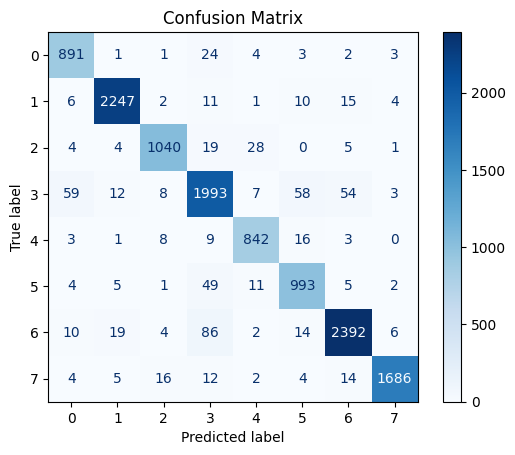

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = np.argmax(y_train, axis=1)
y_pred = preds
# Genera la confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Visualizza la confusion matrix con le etichette
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  
# Usa una mappa di colori blu
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.neural_network.save('/gdrive/MyDrive/weights.keras')

## 📊 Prepare Your SubmissionTo prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:```python# file: model.pyclass Model:    def __init__(self):        """Initialize the internal state of the model."""    def predict(self, X):        """Return a numpy array with the labels corresponding to the input X."""```The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [156]:
class Model2:    
    def __init__(self):        
        # Carica il modello senza compilazione        
        self.neural_network = tfk.models.load_model('/kaggle/working/weights_normal.keras')    
        
    def test(self, X_test, y_test):        
        test_loss, test_acc = self.neural_network.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [157]:
model3 = Model2()
model3.test(X_test2, y_test2)

W0000 00:00:1731935058.702457     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.703967     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.705304     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.706610     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.707904     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.709183     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.710514     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.711828     212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935058.713178     212 gp

429/430 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9589 - loss: 0.1272

W0000 00:00:1731935169.645263     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.646427     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.647524     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.648622     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.649680     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.650747     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.651829     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.652924     211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731935169.654054     211 gp

430/430 ━━━━━━━━━━━━━━━━━━━━ 118s 258ms/step - accuracy: 0.9584 - loss: 0.1289
Test accuracy: 0.8540591597557068


In [ ]:
from datetime import datetimefilename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'# Add files to the zip command if needed!zip {filename} model.py weights.kerasfrom google.colab import filesfiles.download(filename)

	zip warning: name not matched: model.py
	zip warning: name not matched: weights.keras

zip error: Nothing to do! (submission_241108_182910.zip)

FileNotFoundError: Cannot find file: submission_241108_182910.zip